#### https://keras.io/api/applications/xception/

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import os

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
epochs = 500 # quantidade de vezes a ser executado o algoritmo, uma epoch é quanto todo o conjunto de treino foi utilizado
batch = 32 # número de amostras que será carregado a cada execução

In [3]:
#carrega o modelo da InceptionResNetV2 com os pesos aprendidos no treino da InceptionResNetV2 sem a camada densa (include_top=False)
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)

In [4]:
# O restante do modelo e suas camadas são discutidos a seguir 
# x recebe o final da InceptionResNetV2
x=base_model.output

In [5]:
#Nova configuração para o modelo

#adiciona apos x uma camada GlobalMaxPooling2D e atribui este no a x novamente (logo x e o topo novamente)
x=tf.keras.layers.GlobalMaxPooling2D()(x)

#adiciona apos x uma camada densa com 128 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(128,activation='relu')(x)

#adiciona apos x uma camada densa com 64 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(64,activation='relu')(x)

#adiciona apos x uma camada densa com 32 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(32,activation='relu')(x)

#adiciona após x os neurônios que devem ser utilizados, nesse caso foram desligados 20% dos neuronios
x=tf.keras.layers.Dropout(0.5)(x)

#adiciona apos x uma camada densa com 7 neuronios (sete classes) com funcao de ativacao softmax (distribuicao de probabilidade). Atribui este no a preds
#preds=tf.keras.layers.Dense(3,activation='softmax')(x)
preds=tf.keras.layers.Dense(3,activation='sigmoid')(x)

#definindo modelo final
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

#mostrando modelo final e sua estrutura
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [6]:
#congelando os neuronios já treinados na ImageNet, queremos retreinar somente a ultima camada
for l in model.layers:
    if l.name.split('_')[0] != 'dense':
        l.trainable=False
    else:
        l.trainable=True

In [7]:
#iniciando objeto que apanhara todas as imagens de treino, processando as imagens com o metodo da ResNet50V2
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) #included in our dependencies

#iniciando objeto que apanhara todas as imagens de teste, processando as imagens com o metodo da ResNet50V2
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [8]:
#CARREGANDO PRÓPRIO DATASET PARA USO
# target_size=(224, 224)

#definindo gerador de imagens de treino
train_generator = train_data_gen.flow_from_directory('shapes_split/train',
                                                 target_size=(128, 128), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

#definindo gerador de imagens de teste
test_generator = test_data_gen.flow_from_directory('shapes_split/test',
                                                 target_size=(128, 128), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [9]:
lr = tf.keras.optimizers.Adam(learning_rate=0.001) #estabelecendo taxa de otimização

model.compile(optimizer=lr, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#definicao dos steps
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

In [11]:
#treinando e testando o modelo
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=epochs,
                   validation_data=test_generator,
                   validation_steps=step_size_test)

Epoch 1/500


c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


7/7 [==============================] - 12s 1s/step - loss: 0.9452 - accuracy: 0.5145 - val_loss: 0.2771 - val_accuracy: 0.9688
Epoch 2/500
7/7 [==============================] - 7s 1s/step - loss: 0.3169 - accuracy: 0.8931 - val_loss: 0.0580 - val_accuracy: 1.0000
Epoch 3/500
7/7 [==============================] - 8s 1s/step - loss: 0.0932 - accuracy: 0.9743 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 4/500
7/7 [==============================] - 8s 1s/step - loss: 0.0757 - accuracy: 0.9791 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 5/500
7/7 [==============================] - 8s 1s/step - loss: 0.0429 - accuracy: 0.9938 - val_loss: 0.0196 - val_accuracy: 1.0000
Epoch 6/500
7/7 [==============================] - 9s 1s/step - loss: 0.0631 - accuracy: 0.9706 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 7/500
7/7 [==============================] - 8s 1s/step - loss: 0.0344 - accuracy: 0.9820 - val_loss: 0.0259 - val_accuracy: 0.9688
Epoch 8/500
7/7 [============================

7/7 [==============================] - 8s 1s/step - loss: 0.0017 - accuracy: 0.9988 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 60/500
7/7 [==============================] - 8s 1s/step - loss: 0.0080 - accuracy: 0.9962 - val_loss: 2.1431e-04 - val_accuracy: 1.0000
Epoch 61/500
7/7 [==============================] - 8s 1s/step - loss: 0.0142 - accuracy: 0.9887 - val_loss: 6.1477e-05 - val_accuracy: 1.0000
Epoch 62/500
7/7 [==============================] - 8s 1s/step - loss: 0.0301 - accuracy: 0.9717 - val_loss: 1.5048e-04 - val_accuracy: 1.0000
Epoch 63/500
7/7 [==============================] - 8s 1s/step - loss: 0.0136 - accuracy: 0.9877 - val_loss: 6.3330e-08 - val_accuracy: 1.0000
Epoch 64/500
7/7 [==============================] - 8s 1s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 65/500
7/7 [==============================] - 8s 1s/step - loss: 0.0147 - accuracy: 0.9862 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 66/500
7/7 [======

7/7 [==============================] - 8s 1s/step - loss: 8.5285e-05 - accuracy: 1.0000 - val_loss: 8.5336e-06 - val_accuracy: 1.0000
Epoch 117/500
7/7 [==============================] - 8s 1s/step - loss: 0.0105 - accuracy: 0.9913 - val_loss: 8.5150e-06 - val_accuracy: 1.0000
Epoch 118/500
7/7 [==============================] - 8s 1s/step - loss: 0.0049 - accuracy: 0.9950 - val_loss: 2.7940e-07 - val_accuracy: 1.0000
Epoch 119/500
7/7 [==============================] - 9s 1s/step - loss: 0.0060 - accuracy: 0.9952 - val_loss: 2.8685e-07 - val_accuracy: 1.0000
Epoch 120/500
7/7 [==============================] - 8s 1s/step - loss: 3.0500e-04 - accuracy: 1.0000 - val_loss: 9.1294e-06 - val_accuracy: 1.0000
Epoch 121/500
7/7 [==============================] - 8s 1s/step - loss: 0.0076 - accuracy: 0.9931 - val_loss: 8.9136e-06 - val_accuracy: 1.0000
Epoch 122/500
7/7 [==============================] - 8s 1s/step - loss: 0.0081 - accuracy: 0.9931 - val_loss: 8.9510e-06 - val_accuracy: 1.000

Epoch 173/500
7/7 [==============================] - 8s 1s/step - loss: 0.0161 - accuracy: 0.9880 - val_loss: 4.9378e-05 - val_accuracy: 1.0000
Epoch 174/500
7/7 [==============================] - 8s 1s/step - loss: 3.0888e-04 - accuracy: 1.0000 - val_loss: 2.0352e-05 - val_accuracy: 1.0000
Epoch 175/500
7/7 [==============================] - 8s 1s/step - loss: 7.1877e-05 - accuracy: 1.0000 - val_loss: 4.1794e-05 - val_accuracy: 1.0000
Epoch 176/500
7/7 [==============================] - 9s 1s/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 3.0183e-04 - val_accuracy: 1.0000
Epoch 177/500
7/7 [==============================] - 8s 1s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 178/500
7/7 [==============================] - 8s 1s/step - loss: 1.1682e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 179/500
7/7 [==============================] - 8s 1s/step - loss: 0.0061 - accuracy: 0.9948 - val_loss: 7.1294e-06 - val_accur

7/7 [==============================] - 8s 1s/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 2.9168e-06 - val_accuracy: 1.0000
Epoch 230/500
7/7 [==============================] - 9s 1s/step - loss: 0.0045 - accuracy: 0.9965 - val_loss: 2.4775e-05 - val_accuracy: 1.0000
Epoch 231/500
7/7 [==============================] - 8s 1s/step - loss: 5.3578e-04 - accuracy: 1.0000 - val_loss: 4.6193e-07 - val_accuracy: 1.0000
Epoch 232/500
7/7 [==============================] - 8s 1s/step - loss: 4.0176e-05 - accuracy: 1.0000 - val_loss: 1.6440e-05 - val_accuracy: 1.0000
Epoch 233/500
7/7 [==============================] - 9s 1s/step - loss: 8.0643e-04 - accuracy: 1.0000 - val_loss: 2.7567e-07 - val_accuracy: 1.0000
Epoch 234/500
7/7 [==============================] - 8s 1s/step - loss: 0.0152 - accuracy: 0.9892 - val_loss: 1.1599e-05 - val_accuracy: 1.0000
Epoch 235/500
7/7 [==============================] - 8s 1s/step - loss: 1.0292e-05 - accuracy: 1.0000 - val_loss: 1.0146e-05 - val_accurac

7/7 [==============================] - 8s 1s/step - loss: 4.5695e-04 - accuracy: 1.0000 - val_loss: 3.9240e-05 - val_accuracy: 1.0000
Epoch 286/500
7/7 [==============================] - 8s 1s/step - loss: 0.0024 - accuracy: 0.9981 - val_loss: 2.6077e-08 - val_accuracy: 1.0000
Epoch 287/500
7/7 [==============================] - 9s 1s/step - loss: 7.3013e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 288/500
7/7 [==============================] - 8s 1s/step - loss: 2.3179e-04 - accuracy: 1.0000 - val_loss: 2.5050e-05 - val_accuracy: 1.0000
Epoch 289/500
7/7 [==============================] - 9s 1s/step - loss: 0.0092 - accuracy: 0.9893 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 290/500
7/7 [==============================] - 8s 1s/step - loss: 2.6214e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 291/500
7/7 [==============================] - 9s 1s/step - loss: 7.4427e-04 - accuracy: 1.0000 - val_loss: 1.6153e-05 - val_acc

7/7 [==============================] - 8s 1s/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 342/500
7/7 [==============================] - 8s 1s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 343/500
7/7 [==============================] - 8s 1s/step - loss: 6.3710e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 344/500
7/7 [==============================] - 8s 1s/step - loss: 0.0055 - accuracy: 0.9974 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 345/500
7/7 [==============================] - 8s 1s/step - loss: 7.5949e-06 - accuracy: 1.0000 - val_loss: 2.0404e-05 - val_accuracy: 1.0000
Epoch 346/500
7/7 [==============================] - 9s 1s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 3.2486e-05 - val_accuracy: 1.0000
Epoch 347/500
7/7 [==============================] - 8s 1s/step - loss: 0.0043 - accuracy: 0.9974 - val_loss: 4.1484e-05 - val_accuracy: 1.000

7/7 [==============================] - 8s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 9.6806e-06 - val_accuracy: 1.0000
Epoch 398/500
7/7 [==============================] - 8s 1s/step - loss: 4.8174e-05 - accuracy: 1.0000 - val_loss: 9.9673e-06 - val_accuracy: 1.0000
Epoch 399/500
7/7 [==============================] - 8s 1s/step - loss: 3.6662e-05 - accuracy: 1.0000 - val_loss: 8.9407e-08 - val_accuracy: 1.0000
Epoch 400/500
7/7 [==============================] - 8s 1s/step - loss: 5.7312e-10 - accuracy: 1.0000 - val_loss: 8.9407e-08 - val_accuracy: 1.0000
Epoch 401/500
7/7 [==============================] - 8s 1s/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.0150e-05 - val_accuracy: 1.0000
Epoch 402/500
7/7 [==============================] - 8s 1s/step - loss: 1.3791e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 403/500
7/7 [==============================] - 9s 1s/step - loss: 2.7065e-04 - accuracy: 1.0000 - val_loss: 1.0131e-05 - val_acc

7/7 [==============================] - 9s 1s/step - loss: 1.5316e-05 - accuracy: 1.0000 - val_loss: 6.9649e-05 - val_accuracy: 1.0000
Epoch 454/500
7/7 [==============================] - 8s 1s/step - loss: 1.8341e-06 - accuracy: 1.0000 - val_loss: 7.1485e-05 - val_accuracy: 1.0000
Epoch 455/500
7/7 [==============================] - 8s 1s/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 7.4506e-09 - val_accuracy: 1.0000
Epoch 456/500
7/7 [==============================] - 8s 1s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 3.7253e-09 - val_accuracy: 1.0000
Epoch 457/500
7/7 [==============================] - 9s 1s/step - loss: 5.1438e-06 - accuracy: 1.0000 - val_loss: 2.4027e-06 - val_accuracy: 1.0000
Epoch 458/500
7/7 [==============================] - 8s 1s/step - loss: 7.1686e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 459/500
7/7 [==============================] - 9s 1s/step - loss: 2.1829e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_acc

In [12]:
#Avaliando o modelo
loss_train, train_acc = model.evaluate_generator(train_generator, steps=step_size_train)
loss_test, test_acc = model.evaluate_generator(test_generator, steps=step_size_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 1.000, Test: 1.000


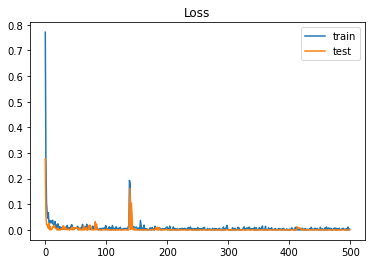

In [13]:
#Apresentando resultados em graficos
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

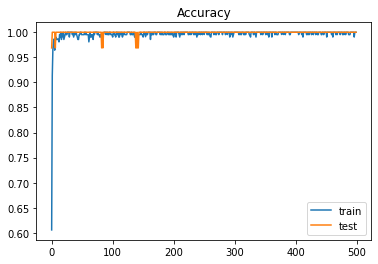

In [14]:
# Criando graficos para visualização dos resultados
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [15]:
print('Criando classificações..')
labels = os.listdir('shapes_split/test')
print('Rótulos', labels)
#criando estruturas para métricas de avaliação, processo um pouco mais demorado
Y_pred = model.predict_generator(test_generator)
print('Preds Created')
y_pred = np.argmax(Y_pred, axis=1)
print('Preds 1D created')

Criando classificações..
Rótulos ['circles', 'squares', 'triangles']


c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Preds Created
Preds 1D created


----------------CLASSIFICATION--------------
              precision    recall  f1-score   support

     circles       0.30      0.30      0.30        20
     squares       0.45      0.45      0.45        20
   triangles       0.40      0.40      0.40        20

    accuracy                           0.38        60
   macro avg       0.38      0.38      0.38        60
weighted avg       0.38      0.38      0.38        60

----------------MATRIX--------------


<AxesSubplot:>

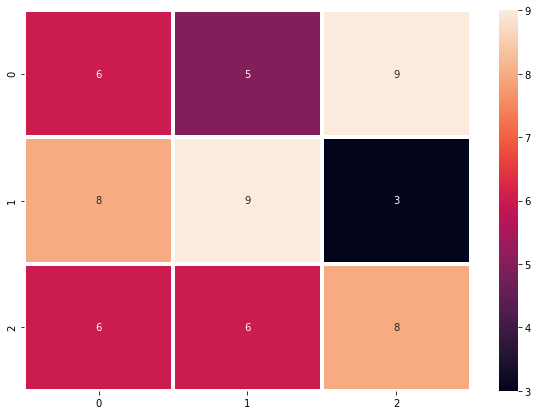

In [16]:
classification = classification_report(test_generator.classes, y_pred, target_names=labels)
print('----------------CLASSIFICATION--------------')
print(classification)
matrix = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(3)],
                  columns = [i for i in range(3)])
plt.figure(figsize = (10,7))
print('----------------MATRIX--------------')
sn.heatmap(df_cm, annot=True, linewidths=2.5)